In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import numpy as np
# import deeplake
import matplotlib.pyplot as plt
from tensorflow.keras.losses import CategoricalCrossentropy

In [4]:
from google.colab import files
uploaded = files.upload()


Saving archive (7).zip to archive (7).zip


In [5]:
import zipfile
import os

zip_path = '/content/archive (7).zip'  # or use the exact filename
extract_path = '/content/fer2013_extracted'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [6]:
import pandas as pd

def build_csv(data_dir, output_csv):
    data = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            data.append({'path': img_path, 'label': label})

    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Saved: {output_csv} — {len(df)} entries")




In [7]:
import shutil
import os
# data 77777777777777777
def remove_extra_classes(base_path, keep_classes):
    for split in ['train', 'test']:
        split_path = os.path.join(base_path, split)
        for cls in os.listdir(split_path):
            cls_path = os.path.join(split_path, cls)
            if cls not in keep_classes and os.path.isdir(cls_path):
                print(f"Removing: {cls_path}")
                shutil.rmtree(cls_path)

# Only keep these
target_classes = ['anger', 'happiness', 'neutral', 'sadness']
remove_extra_classes('/content/fer2013_extracted/fer2013plus/fer2013', target_classes)


Removing: /content/fer2013_extracted/fer2013plus/fer2013/train/fear
Removing: /content/fer2013_extracted/fer2013plus/fer2013/train/surprise
Removing: /content/fer2013_extracted/fer2013plus/fer2013/train/disgust
Removing: /content/fer2013_extracted/fer2013plus/fer2013/train/contempt
Removing: /content/fer2013_extracted/fer2013plus/fer2013/test/fear
Removing: /content/fer2013_extracted/fer2013plus/fer2013/test/surprise
Removing: /content/fer2013_extracted/fer2013plus/fer2013/test/disgust
Removing: /content/fer2013_extracted/fer2013plus/fer2013/test/contempt


In [8]:
build_csv('/content/fer2013_extracted/fer2013plus/fer2013/train', 'combined_data.csv')
build_csv('/content/fer2013_extracted/fer2013plus/fer2013/test', 'temp_test.csv')

# Merge both CSVs
df_train = pd.read_csv('combined_data.csv')
df_test = pd.read_csv('temp_test.csv')
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.to_csv('full_fer_4class.csv', index=False)


Saved: combined_data.csv — 23816 entries
Saved: temp_test.csv — 5924 entries


In [9]:
import pandas as pd

def downsample_csv(input_csv, output_csv, max_per_class=5000):
    df = pd.read_csv(input_csv)

    # Group by label and sample up to max_per_class rows per label
    df_balanced = df.groupby('label').apply(
        lambda x: x.sample(n=min(len(x), max_per_class), random_state=42)
    )

    df_balanced = df_balanced.reset_index(drop=True)
    df_balanced.to_csv(output_csv, index=False)

    print(f"✅ Downsampled to max {max_per_class} per class.")
    print(df_balanced['label'].value_counts())
    print(f"📝 Saved to: {output_csv}")

    return df_balanced

downsample_csv('full_fer_4class.csv', 'train_data_balanced.csv', max_per_class=5000)


✅ Downsampled to max 5000 per class.
label
happiness    5000
neutral      5000
sadness      4370
anger        3110
Name: count, dtype: int64
📝 Saved to: train_data_balanced.csv


/tmp/ipython-input-9-3971415975.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(


,path,label
0,/content/fer2013_extracted/fer2013plus/fer2013...,anger
1,/content/fer2013_extracted/fer2013plus/fer2013...,anger
2,/content/fer2013_extracted/fer2013plus/fer2013...,anger
3,/content/fer2013_extracted/fer2013plus/fer2013...,anger
4,/content/fer2013_extracted/fer2013plus/fer2013...,anger
...,...,...
17475,/content/fer2013_extracted/fer2013plus/fer2013...,sadness
17476,/content/fer2013_extracted/fer2013plus/fer2013...,sadness
17477,/content/fer2013_extracted/fer2013plus/fer2013...,sadness
17478,/content/fer2013_extracted/fer2013plus/fer2013...,sadness


In [10]:
# toooo minnnnnn
def downsample_to_min_class(input_csv, output_csv):
    import pandas as pd

    df = pd.read_csv(input_csv)
    min_count = df['label'].value_counts().min()
    print(f"📉 Downsampling each class to {min_count} samples")

    df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=42))
    df_balanced = df_balanced.reset_index(drop=True)
    df_balanced.to_csv(output_csv, index=False)

    print(f"✅ Saved balanced dataset to {output_csv} — total: {len(df_balanced)} rows")

    return df_balanced

# Example usage
train_balanced = downsample_to_min_class('full_fer_4class.csv', 'train_data_balanced.csv')


📉 Downsampling each class to 3110 samples
✅ Saved balanced dataset to train_data_balanced.csv — total: 12440 rows


/tmp/ipython-input-10-1737254372.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('label').apply(lambda x: x.sample(n=min_count, random_state=42))


In [11]:
import cv2
# Detect blurry images using Laplacian variance
def is_blurry(img, threshold=100):
    return cv2.Laplacian(img, cv2.CV_64F).var() < threshold

# Detect low contrast images using standard deviation
def is_low_contrast(img, threshold=20):
    return img.std() < threshold


In [12]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def load_images_from_csv(csv_path, img_size=(48, 48)):
    df = pd.read_csv(csv_path)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    images, labels = [], []
    skipped = 0
    for _, row in df.iterrows():
        img = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Quality filtering
        if is_blurry(img) or is_low_contrast(img):
            skipped += 1
            continue
        img = cv2.resize(img, img_size)
        images.append(img)
        labels.append(row['label'])

    # Reshape and normalize
    X = np.array(images).reshape(-1, 48, 48, 1).astype('float32') / 255.0


    # Encode labels
    le = LabelEncoder()
    y_int = le.fit_transform(labels)
    y = to_categorical(y_int)

    return X, y, le

# Load the data
X, y, label_encoder = load_images_from_csv('train_data_balanced.csv')
print("✅ Images loaded:", X.shape)
print("✅ Labels shape:", y.shape)
print("🧾 Classes:", label_encoder.classes_)


✅ Images loaded: (12413, 48, 48, 1)
✅ Labels shape: (12413, 4)
🧾 Classes: ['anger' 'happiness' 'neutral' 'sadness']


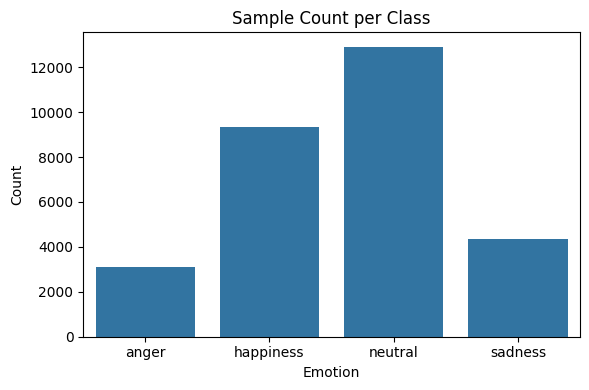

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

df_balanced = pd.read_csv('full_fer_4class.csv')
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='label', order=sorted(df_balanced['label'].unique()))
plt.title("Sample Count per Class")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


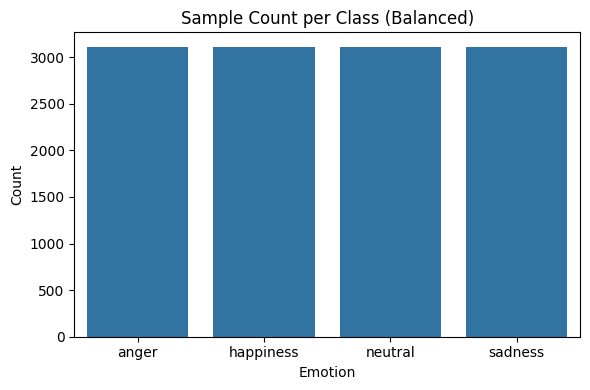

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df_balanced = pd.read_csv('train_data_balanced.csv')
plt.figure(figsize=(6, 4))
sns.countplot(data=df_balanced, x='label', order=sorted(df_balanced['label'].unique()))
plt.title("Sample Count per Class (Balanced)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

print(f"🟩 Training samples: {len(X_train)}, Validation samples: {len(X_val)}")


🟩 Training samples: 9930, Validation samples: 2483


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True
)


In [17]:
train_generator = datagen.flow(X_train, y_train, batch_size=16,shuffle=True)
val_generator = datagen.flow(X_val, y_val, batch_size=16,shuffle=True)

In [18]:

from tensorflow.keras.losses import CategoricalCrossentropy
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def build_model(hp):
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', [32,64]),
        kernel_size=3,
        activation='relu',
        padding='same',
        input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Second Conv Block
    model.add(Conv2D(hp.Choice('conv2_filters', [32,64, 128]), (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    # model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    # Third Conv Block
    model.add(Conv2D(hp.Choice('conv3_filters', [ 128,256]), (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Fourth Conv Block
    model.add(Conv2D(hp.Choice('conv4_filters', [128,256]), (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Fifth Conv Block
    model.add(Conv2D(hp.Choice('conv5_filters', [128,256]), (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Fully Connected
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy'])

    return model


In [19]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
weights = compute_class_weight(class_weight='balanced',
                                classes=np.unique(y_train.argmax(axis=1)),
                                y=y_train.argmax(axis=1))
class_weight_dict = dict(enumerate(weights))
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='/content/drive/MyDrive/keras_tuner_logs',
    project_name='fer2013_4class'
)

tuner.search(train_generator,
             epochs=100,
             validation_data=val_generator,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=6),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)],
             batch_size=16,
             class_weight=class_weight_dict)
tuner.results_summary()

Trial 10 Complete [00h 10m 35s]
val_accuracy: 0.7962142825126648

Best val_accuracy So Far: 0.7962142825126648
Total elapsed time: 01h 20m 00s
Results summary
Results in /content/drive/MyDrive/keras_tuner_logs/fer2013_4class
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 64
conv3_filters: 256
conv4_filters: 256
conv5_filters: 128
Score: 0.7962142825126648

Trial 06 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 128
conv3_filters: 256
conv4_filters: 256
conv5_filters: 128
Score: 0.7829238772392273

Trial 07 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 64
conv3_filters: 128
conv4_filters: 256
conv5_filters: 128
Score: 0.7805074453353882

Trial 01 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 32
conv3_filters: 256
conv4_filters: 128
conv5_filters: 256
Score: 0.7784937620162964

Trial 00 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 64
conv3_filters: 2

In [20]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hp)

history = model.fit(train_generator,
             epochs=100,
             validation_data=val_generator,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=6),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)],
             batch_size=16,
             class_weight=class_weight_dict)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.2868 - loss: 1.5666 - val_accuracy: 0.2867 - val_loss: 1.4488 - learning_rate: 0.0010
Epoch 2/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3360 - loss: 1.3636 - val_accuracy: 0.3621 - val_loss: 1.3324 - learning_rate: 0.0010
Epoch 3/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4075 - loss: 1.3009 - val_accuracy: 0.4543 - val_loss: 1.2341 - learning_rate: 0.0010
Epoch 4/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.4772 - loss: 1.2039 - val_accuracy: 0.4567 - val_loss: 1.2758 - learning_rate: 0.0010
Epoch 5/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5357 - loss: 1.1390 - val_accuracy: 0.5042 - val_loss: 1.2195 - learning_rate: 0.0010
Epoch 6/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5722 - loss: 1.0848 - val_accuracy: 0.5473 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 7/100
621/621 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6017 

In [21]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"📊 Final Validation Accuracy: {val_acc:.4f}")


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7970 - loss: 0.7141
📊 Final Validation Accuracy: 0.7845


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


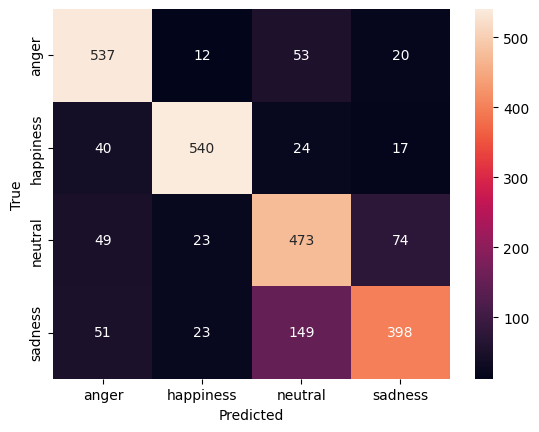

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_val).argmax(axis=1)
y_true = y_val.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


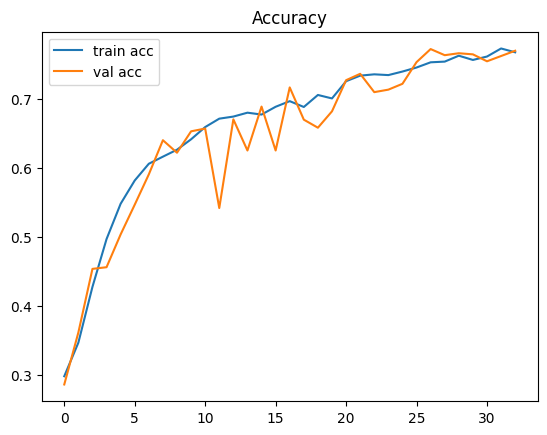

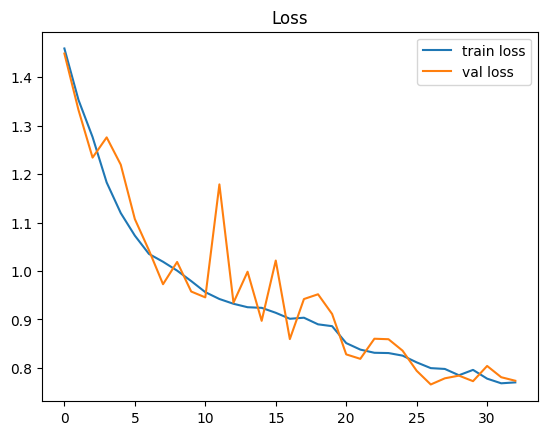

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Use same class labels as in confusion matrix
class_names = label_encoder.classes_

# Print full precision/recall/F1 report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)


              precision    recall  f1-score   support

       anger     0.7932    0.8633    0.8268       622
   happiness     0.9030    0.8696    0.8860       621
     neutral     0.6767    0.7641    0.7178       619
     sadness     0.7819    0.6409    0.7044       621

    accuracy                         0.7845      2483
   macro avg     0.7887    0.7845    0.7837      2483
weighted avg     0.7888    0.7845    0.7838      2483

